In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
import numpy as np
import pandas as pd
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
housing = pd.read_csv("housing.csv")
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].value_counts()
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
housing = strat_train_set.drop("income_cat", axis=1)
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels_train = strat_train_set["median_house_value"].copy()
housing_num = housing.drop("ocean_proximity", axis=1)
num_pipeline = Pipeline([
        ('imputer', imputer),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

b=num_pipeline.fit_transform(housing_num)
from sklearn.preprocessing import LabelBinarizer
housing_cat = housing["ocean_proximity"]
encoder = LabelBinarizer()
a=encoder.fit_transform(housing_cat)
housing_train=np.concatenate((b,a),axis=1)

housing = strat_test_set.drop("income_cat", axis=1)
housing = strat_test_set.drop("median_house_value", axis=1)
housing_labels_test = strat_test_set["median_house_value"].copy()
housing_num = housing.drop("ocean_proximity", axis=1)
num_pipeline = Pipeline([
        ('imputer', imputer),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

b=num_pipeline.fit_transform(housing_num)
from sklearn.preprocessing import LabelBinarizer
housing_cat = housing["ocean_proximity"]
encoder = LabelBinarizer()
a=encoder.fit_transform(housing_cat)
housing_test=np.concatenate((b,a),axis=1)







In [4]:
housing_train.shape


(16512, 17)

In [5]:
housing_test.shape

(4128, 17)

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

In [7]:
n1 = RandomForestRegressor(n_estimators=16, max_depth=10)
n2 = MLPRegressor(hidden_layer_sizes=(9),activation='logistic',max_iter=10000,random_state=1,solver='lbfgs')
n4 = Pipeline([('poly', PolynomialFeatures(degree=3)),
               ('linear', LinearRegression(fit_intercept=False))])

In [9]:
train_scores_mean2=[]
test_scores_mean2 =[]
train_scores_std2=[]
test_scores_std2=[]
for i in range (1,4):
    rf = Pipeline([('poly', PolynomialFeatures(degree=i)),
               ('linear', LinearRegression(fit_intercept=False))])
    cr = cross_validate(rf, housing_train, np.ravel(housing_labels_train), scoring= "neg_root_mean_squared_error", cv=5,return_train_score=True)
    print("train :",np.average(cr['train_score']),flush=True)
    print("test :",np.average(cr['test_score']),flush=True)
    train_scores_mean2.append(np.sqrt(np.average(cr['train_score'])))
    test_scores_mean2.append(np.sqrt(np.average(cr['test_score'])))
    train_scores_std2.append(np.std(cr['train_score']))
    test_scores_std2.append(np.std(cr['test_score']))



train : -68322.7583142594
test : -68874.67758888853


/Users/boyaouyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
/Users/boyaouyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


train : -58623.10165279494
test : -85259895442348.5


/Users/boyaouyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
/Users/boyaouyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


train : -50736.14602977653
test : -573687359478.2416


/Users/boyaouyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
/Users/boyaouyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


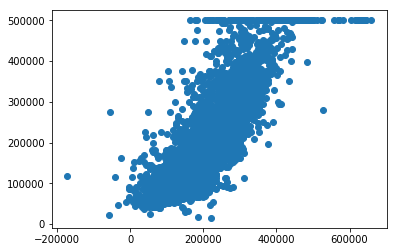

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import font_manager

rf = Pipeline([('poly', PolynomialFeatures(degree=1)),
               ('linear', LinearRegression(fit_intercept=False))])
rf.fit(housing_train,housing_labels_train )
prediction=rf.predict(housing_test)
plt.scatter(prediction,housing_labels_test)

Text(0, 0.5, 'Actual housing price ($)')

/Users/boyaouyang/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


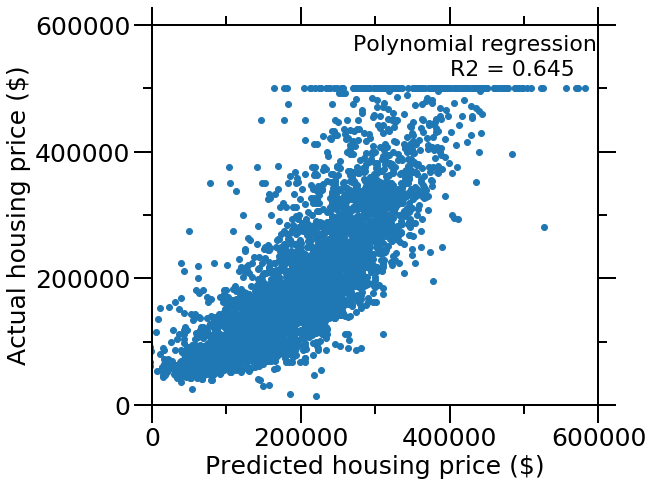

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import font_manager
fig=plt.figure(figsize=(8,7))
ax=plt.axes()
rf = Pipeline([('poly', PolynomialFeatures(degree=1)),
               ('linear', LinearRegression(fit_intercept=False))])
rf.fit(housing_train,housing_labels_train )
prediction=rf.predict(housing_test)
plt.scatter(prediction,housing_labels_test)
ax.minorticks_on()
ax.tick_params('both',top=True,right=True, length=18, width=2, which='major',labelsize=25)
ax.tick_params('both', top=True,right=True,length=9,width=2,  which='minor')
ax.xaxis.set_minor_locator(MultipleLocator(100000))
ax.yaxis.set_minor_locator(MultipleLocator(100000))
ax.xaxis.set_major_locator(MultipleLocator(200000))
ax.yaxis.set_major_locator(MultipleLocator(200000))
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.rc('legend',fontsize=25) 

plt.ylim(0,600000)
plt.xlim(0,600000)
plt.text(270000, 560000, "Polynomial regression", family='Helvetica',fontsize=22)
plt.text(400000, 520000, "R2 = 0.645", family='Helvetica',fontsize=22)
plt.xlabel("Predicted housing price ($)",fontsize=25,family='Helvetica')
plt.ylabel("Actual housing price ($)",fontsize=25,family='Helvetica')

In [17]:
housing_labels_test.shape

(16512,)

In [ ]:
from sklearn.linear_model import Lasso
train_scores_mean2=[]
test_scores_mean2 =[]
train_scores_std2=[]
test_scores_std2=[]
for i in range (1,4):
    rf = Pipeline([('poly', PolynomialFeatures(degree=i)),
               ('lasso',  Lasso(random_state=42, max_iter=1000000))])
    cr = cross_validate(rf, housing_train, np.ravel(housing_labels_train), scoring= "r2", cv=5,return_train_score=True)
    print("train :",np.average(cr['train_score']),flush=True)
    print("test :",np.average(cr['test_score']),flush=True)
    train_scores_mean2.append(np.average(cr['train_score']))
    test_scores_mean2.append(np.average(cr['test_score']))
    train_scores_std2.append(np.std(cr['train_score']))
    test_scores_std2.append(np.std(cr['test_score']))




In [15]:
train_scores_mean2=[]
test_scores_mean2 =[]
train_scores_std2=[]
test_scores_std2=[]
for i in range (1,20):
    rf = RandomForestRegressor(n_estimators=i, max_depth=10)
    cr = cross_validate(rf, housing_train, np.ravel(housing_labels_train), scoring= "r2", cv=5,return_train_score=True)
    print("train :",np.average(cr['train_score']),flush=True)
    print("test :",np.average(cr['test_score']),flush=True)
    train_scores_mean2.append(np.average(cr['train_score']))
    test_scores_mean2.append(np.average(cr['test_score']))
    train_scores_std2.append(np.std(cr['train_score']))
    test_scores_std2.append(np.std(cr['test_score']))

train : 0.7895419078005371
test : 0.6774007103340054
train : 0.8332262931971629
test : 0.7327221453488185
train : 0.846758959006392
test : 0.7587224217887922
train : 0.8528492002928884
test : 0.7598252591941054
train : 0.8606876322479511
test : 0.7635191104629001
train : 0.8597694042793191
test : 0.7725781681101722
train : 0.8628193867619955
test : 0.7711080757517905
train : 0.865188081444973
test : 0.7748516601911236
train : 0.8653228666246591
test : 0.7779629501861531
train : 0.8654873133136455
test : 0.7769515840341079
train : 0.8673020870175072
test : 0.778434371981675
train : 0.8676912973783646
test : 0.7789330553432585
train : 0.8701827960706755
test : 0.779120569823651
train : 0.8685560700375732
test : 0.7785867138647645
train : 0.8694007020760317
test : 0.7821895378250536


KeyboardInterrupt: 

In [17]:
len(train_scores_mean2)

15

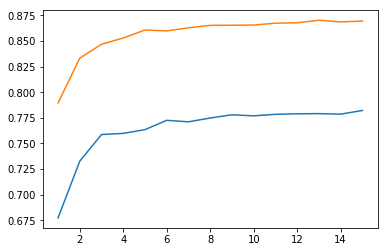

In [19]:
a=[]
for i in range (1,16):
    a.append(i)
plt.plot(a,test_scores_mean2)
plt.plot(a,train_scores_mean2)

In [39]:
train_scores_mean2=[]
test_scores_mean2 =[]
train_scores_std2=[]
test_scores_std2=[]
for i in range (1,15):
    rf = RandomForestRegressor(n_estimators=i, max_depth=10)
    cr = cross_validate(rf, housing_train, np.ravel(housing_labels_train), scoring= "r2", cv=5,return_train_score=True)
    print("train :",np.average(cr['train_score']),flush=True)
    print("test :",np.average(cr['test_score']),flush=True)
    train_scores_mean2.append(np.average(cr['train_score']))
    test_scores_mean2.append(np.average(cr['test_score']))
    train_scores_std2.append(np.std(cr['train_score']))
    test_scores_std2.append(np.std(cr['test_score']))
a=[]
for i in range (1,15):
    a.append(i)
plt.plot(a,test_scores_mean2)
plt.plot(a,train_scores_mean2)

train : 0.7883189277856124
test : 0.6742739404653773
train : 0.8344217504069494
test : 0.7332615342344925
train : 0.847133310699071
test : 0.7489472386869145
train : 0.8525296662791904
test : 0.7582894027879673
train : 0.8574738757833071
test : 0.7669636961983709
train : 0.8608642475142456
test : 0.772036260149695
train : 0.861943274715039
test : 0.7706095484334375
train : 0.86434896047168
test : 0.7715054190203764
train : 0.8648828010757963
test : 0.7768070739538697
train : 0.8669358383436496
test : 0.7750504839897239
train : 0.868154630173235
test : 0.7799983561629805
train : 0.8690076742404139
test : 0.7805455271146174


KeyboardInterrupt: 

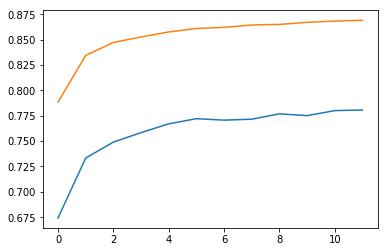

In [47]:
plt.plot(a,test_scores_mean2)
plt.plot(a,train_scores_mean2)




Text(0.5, 0, 'Predicted housing price ($)')

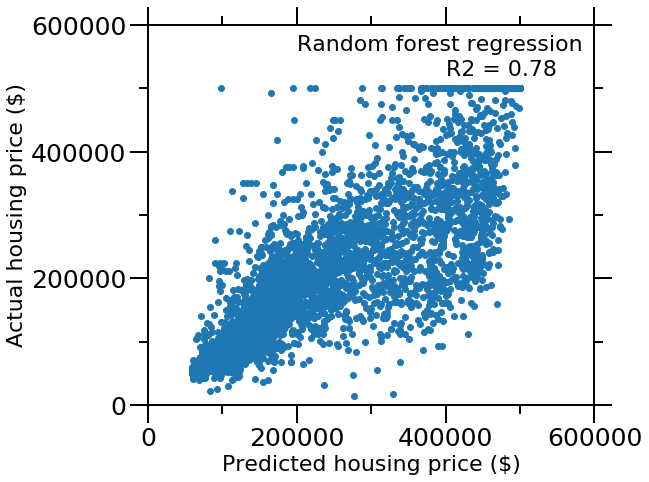

In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import font_manager
fig=plt.figure(figsize=(8,7))
ax=plt.axes()
rf = RandomForestRegressor(n_estimators=15, max_depth=10)
rf.fit(housing_train,housing_labels_train )
prediction=rf.predict(housing_test)
plt.scatter(prediction,housing_labels_test)
ax.minorticks_on()
ax.tick_params('both',top=True,right=True, length=18, width=2, which='major',labelsize=25)
ax.tick_params('both', top=True,right=True,length=9,width=2,  which='minor')
ax.xaxis.set_minor_locator(MultipleLocator(100000))
ax.yaxis.set_minor_locator(MultipleLocator(100000))
ax.xaxis.set_major_locator(MultipleLocator(200000))
ax.yaxis.set_major_locator(MultipleLocator(200000))
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.rc('legend',fontsize=25) 

plt.ylim(0,600000)
plt.xlim(0,600000)
plt.text(200000, 560000, "Random forest regression", family='Helvetica',fontsize=22)
plt.text(400000, 520000, "R2 = 0.78", family='Helvetica',fontsize=22)
plt.ylabel('Actual housing price ($)',fontsize=22,family='Helvetica')
plt.xlabel('Predicted housing price ($)',fontsize=22,family='Helvetica')

In [52]:
train_scores_mean2=[]
test_scores_mean2 =[]
train_scores_std2=[]
test_scores_std2=[]
for i in range (1,15):
    rf = MLPRegressor(hidden_layer_sizes=(i),activation='logistic',max_iter=10000,random_state=1,solver='lbfgs')
    cr = cross_validate(rf, housing_train, np.ravel(housing_labels_train), scoring= "r2", cv=5,return_train_score=True)
    print("train :",np.average(cr['train_score']),flush=True)
    print("test :",np.average(cr['test_score']),flush=True)
    train_scores_mean2.append(np.average(cr['train_score']))
    test_scores_mean2.append(np.average(cr['test_score']))
    train_scores_std2.append(np.std(cr['train_score']))
    test_scores_std2.append(np.std(cr['test_score']))
a=[]
for i in range (1,15):
    a.append(i)
plt.plot(a,test_scores_mean2)
plt.plot(a,train_scores_mean2)

train : 0.16240292343699952
test : 0.16122954143946952
train : 0.368243433530166
test : 0.3563944025861378
train : 0.48721149500481103
test : 0.4765209830335701
train : 0.4900441658145545
test : 0.48726681265145977
train : 0.5636173989730764
test : 0.5470953082471735


KeyboardInterrupt: 

In [ ]:
n2 = MLPRegressor(hidden_layer_sizes=(9),activation='logistic',max_iter=10000,random_state=1,solver='lbfgs')